# Importing Libraries

In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

# Loading the Datasets

In [13]:
transforms = transforms.Compose([transforms.Resize((224, 224)),# Resize images according to VGG-16 standards
                                 transforms.ToTensor(), # Conveert image to tensor
                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) # Normalize images according to VGG-16 standards

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms) # Download training data
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms) # Download testing data

Files already downloaded and verified
Files already downloaded and verified


# Device Configuration

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Load Pre-Trained Model

In [15]:
model = torchvision.models.vgg16(pretrained=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Freezing the models

In [16]:
for param in model.parameters():
  param.requires_grad = False

Assume we want to fine tune the last 3 layers:

In [17]:
model.classifier[1].requires_grad = True
model.classifier[3].requires_grad = True

For the last year, the number of class labels differ so we replace the output layer with the CIFAR-10 output labels i.e. 10

In [18]:
model.classifier[6] = nn.Linear(4096, 10)

# Setting Hyperparameters

In [27]:
BATCH_SIZE = 64
EPOCH = 10
learning_rate = 0.001

# Load the data using DataLoader

In [28]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

# Defining Loss, Optimizer and Scheuler

In [29]:
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss = nn.CrossEntropyLoss()

In [30]:
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

def train(model, optimizer, loss_fn, trainloader, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(trainloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss_value = loss_fn(outputs, labels)
        loss_value.backward()
        optimizer.step()

        running_loss += loss_value.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss.append(running_loss / len(trainloader))
    train_accuracy.append(correct / total)
    print(f"Training | Loss: {running_loss / len(trainloader)} | Accuracy: {(correct / total) * 100}")

def test(model, loss_fn, testloader, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss_value = loss_fn(outputs, labels)

            running_loss += loss_value.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss.append(running_loss / len(testloader))
    test_accuracy.append(correct / total)
    print(f"Testing | Loss: {running_loss / len(testloader)} | Accuracy: {(correct / total) * 100}")

# Training loop
for epoch in range(EPOCH):
    print(f"EPOCH {epoch + 1}")
    train(model, optimizer, loss, trainloader, device)
    test(model, loss, testloader, device)

EPOCH 1


Training: 100%|██████████| 782/782 [05:30<00:00,  2.36it/s]


Training | Loss: 0.5868479111005583 | Accuracy: 79.462


Testing: 100%|██████████| 157/157 [01:06<00:00,  2.38it/s]


Testing | Loss: 0.481486056830473 | Accuracy: 83.04
EPOCH 2


Training: 100%|██████████| 782/782 [05:31<00:00,  2.36it/s]


Training | Loss: 0.5916424394987733 | Accuracy: 79.838


Testing: 100%|██████████| 157/157 [01:06<00:00,  2.36it/s]


Testing | Loss: 0.47410428723332226 | Accuracy: 83.58
EPOCH 3


Training: 100%|██████████| 782/782 [05:34<00:00,  2.34it/s]


Training | Loss: 0.5867938123776785 | Accuracy: 79.892


Testing: 100%|██████████| 157/157 [01:06<00:00,  2.35it/s]


Testing | Loss: 0.5153688951662392 | Accuracy: 82.25
EPOCH 4


Training: 100%|██████████| 782/782 [05:37<00:00,  2.32it/s]


Training | Loss: 0.5896746582920899 | Accuracy: 80.204


Testing: 100%|██████████| 157/157 [01:06<00:00,  2.35it/s]


Testing | Loss: 0.48229397444208716 | Accuracy: 83.11
EPOCH 5


Training: 100%|██████████| 782/782 [05:30<00:00,  2.36it/s]


Training | Loss: 0.5908201892700646 | Accuracy: 80.048


Testing: 100%|██████████| 157/157 [01:05<00:00,  2.41it/s]


Testing | Loss: 0.47077425507603177 | Accuracy: 83.65
EPOCH 6


Training: 100%|██████████| 782/782 [05:29<00:00,  2.37it/s]


Training | Loss: 0.5912934846013708 | Accuracy: 80.142


Testing: 100%|██████████| 157/157 [01:05<00:00,  2.38it/s]


Testing | Loss: 0.47084587233461395 | Accuracy: 83.58
EPOCH 7


Training: 100%|██████████| 782/782 [05:25<00:00,  2.40it/s]


Training | Loss: 0.5931328106719209 | Accuracy: 80.122


Testing: 100%|██████████| 157/157 [01:06<00:00,  2.38it/s]


Testing | Loss: 0.47305810631840095 | Accuracy: 83.53
EPOCH 8


Training: 100%|██████████| 782/782 [05:31<00:00,  2.36it/s]


Training | Loss: 0.5834752688627414 | Accuracy: 80.55600000000001


Testing: 100%|██████████| 157/157 [01:06<00:00,  2.37it/s]


Testing | Loss: 0.4652002229812039 | Accuracy: 83.91999999999999
EPOCH 9


Training: 100%|██████████| 782/782 [05:35<00:00,  2.33it/s]


Training | Loss: 0.5891932272507102 | Accuracy: 80.264


Testing: 100%|██████████| 157/157 [01:06<00:00,  2.36it/s]


Testing | Loss: 0.47549851476007204 | Accuracy: 83.57
EPOCH 10


Training: 100%|██████████| 782/782 [05:34<00:00,  2.34it/s]


Training | Loss: 0.589702936370507 | Accuracy: 80.34


Testing: 100%|██████████| 157/157 [01:06<00:00,  2.35it/s]

Testing | Loss: 0.47248873143059433 | Accuracy: 83.69


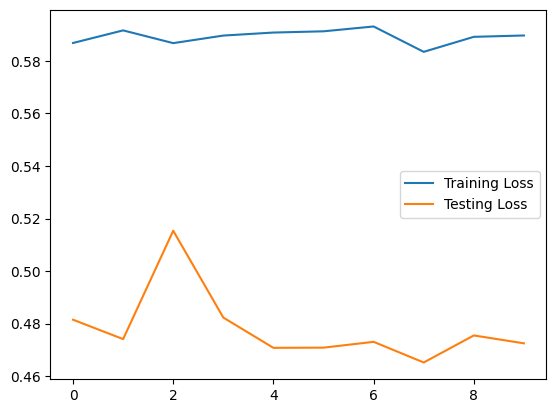

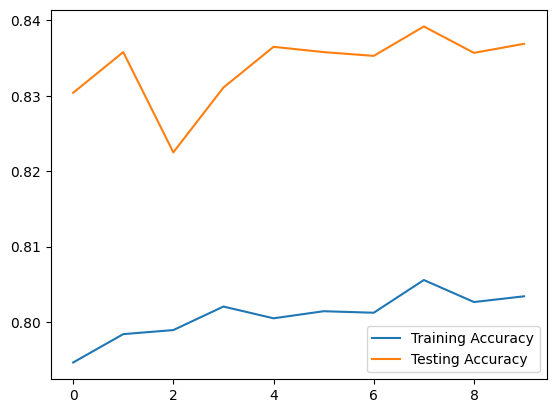

In [31]:
#Plotting Loss and Accuracy

plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.legend()
plt.show()

plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Testing Accuracy')
plt.legend()
plt.show()